# Code to generate a wing
For analysis in OpenVSP from data from FreeCAD lists

In [1]:
import openvsp as vsp
import time
import scipy
import os
import numpy as np
import numpy.polynomial.polynomial as poly
import pandas as pd
import pickle
import plotly.express as px
import plotly.graph_objects as go
import csv
from CODE.basicgeo import P2, P3, interpP3
from CODE.VSPutils import generateWing, v2CL, analyseVLM, getResults, trimCG, CL2v

stdout = vsp.cvar.cstdout
errorMgr = vsp.ErrorMgrSingleton.getInstance()
vsp.GetVSPVersion()

'OpenVSP 3.40.1'

### Copy and paste in the lists from FreeCAD Configurations spreadsheet into cell below 

In [2]:
#xbow
secs = [0.0, 466.332825, 1068.950317, 1646.419556, 2378.06543, 3219.933594, 4135.516602, 4976.60791]
chordsmm = [1962.66687, 1987.5196448199817, 1954.2146835069336, 1914.7599173085641, 1763.9884108574179, 1490.938533817437, 1016.192994, 352.2518309999998]
sweeps = [-4.537751282006804, 7.075437015157452, 17.354512297897873, 23.87103007026493, 26.6878527794197, 29.13589744703327, 33.00663692976908]
dihedrals = [8.5,5.5,1.5,-1,-3,-3,-2]
twists = [-0.7,-1,-2,-4,-6,-8,-9,-10]
ds = [985.511414, 1107.3873208199816, 1207.6250845069337, 1176.541655308564, 1064.9273758574177, 941.416560817437, 696.619263, 352.2518309999998]
rs = [0,0.5,0.75,1]

In [3]:
#PE13
Puma_UI1720full_VG0 = {
    'secs':[0,603.875,1207.75,1811.625,2415.5,3019.375,3623.25,4227.125,4831],
    'chordsmm':[1855, 1746, 1700, 1647, 1568, 1453, 1272, 947,486],
    'sweeps':[23.03,23.09,23.57,24.5,25.7,27.82,31.22,31.86],
    'dihedrals':[0.05,-1.99,-1.99,-2.18,-2.41,-0.57,4.13,4.13],
    'twists':[0, -3.62, -6.78, -8.9, -11.1, -14.8, -18, -20, -20], #VG OFF
    'ds':[1714, 1595, 1515, 1459, 1383, 1282, 1099, 824, 473],
    'root_file':'data/aerofoils/ui1720reflex.csv',
    'mid_file':'data/aerofoils/ui1720mod.csv',
    'outb_file':'data/aerofoils/ui1720mod.csv',
    'tip_file':'data/aerofoils/tipsection.csv',
    'rs':[0,0.5,0.75,1]
}
Puma_UI1720full_VG1 = {
    'secs':[0,603.875,1207.75,1811.625,2415.5,3019.375,3623.25,4227.125,4831],
    'chordsmm':[1855, 1746, 1700, 1647, 1568, 1453, 1272, 947,486],
    'sweeps':[23.03,23.09,23.57,24.5,25.7,27.82,31.22,31.86],
    'dihedrals':[0.05,-1.99,-1.99,-2.18,-2.41,-0.57,4.13,4.13],
    'twists':[0, 0.02, -0.47, -0.81, -2.2, -4.58, -7.74, -10.24, -14.93], #VG ON
    'ds':[1714, 1595, 1515, 1459, 1383, 1282, 1099, 824, 473],
    'root_file':'data/aerofoils/ui1720reflex.csv',
    'mid_file':'data/aerofoils/ui1720mod.csv',
    'outb_file':'data/aerofoils/ui1720mod.csv',
    'tip_file':'data/aerofoils/tipsection.csv',
    'rs':[0,0.5,0.75,1]
}


In [4]:
#Wildcat
secs = [0,603.875,1207.75,1811.625,2415.5,3019.375,3623.25,4227.125,4831]
chordsmm = [1855, 1746, 1700, 1647, 1568, 1453, 1272, 947,486]
sweeps = [23.03,23.09,23.57,24.5,25.7,27.82,31.22,31.86]
dihedrals = [4.75, 4.75, 4.75 , -3, -3, -3, -3, -3]
#twists = [0, -2, -2.75,  -2.75, -5.5, -8, -12, -16, -20]
twists = [-0.0,
 -1.917410455331127,
 -2.1273191480434424,
 -0.39954095871514284,
 -1.4830513550299267,
 -3.2585891905188893,
 -4.247977673025277,
 -6.593942943396353,
 -6.593942943396353]
ds = [1714, 1595, 1515, 1459, 1383, 1282, 1099, 824, 473]
root_file = 'data/aerofoils/ui1720reflex.csv'
mid_file = 'data/aerofoils/ui1720reflex.csv'
outb_file = 'data/aerofoils/ui1720mod.csv'
tip_file = 'data/aerofoils/tipsection.csv'
rs = [0,0.5,0.75,1]

In [5]:
#RioT
secs = [0.0, 512.82, 1229.5, 1957.07, 2723.31, 3355.0, 3991.88, 4417.58]
chordsmm = [2258.95895423, 2033.6988477700002, 1782.04461041, 1601.0909708800002, 1385.6365501, 1171.991467860766, 789.7256825227719, 379.2314459999998]
ds = [1639.058228, 1491.8569677278858, 1299.542453565293, 1177.4288350090994, 1131.1905556399997, 1051.991467860766, 669.7256825227719, 379.2314459999998]
tube_dia = [26,26,26,26,26,26,18,18]
sweeps = [30.974083191099673, 31.184044275836612, 31.784520456538452, 32.127380760981715, 32.12043422287445, 32.8583017855224, 33.769247774472994]
dihedrals = [0,0,0,0,0,3,3]
twists = [0, -3.62, -6.78, -9.5, -12.5, -15.5, -17, -19]
root_file = 'data/aerofoils/ui1720reflex.csv'
mid_file = 'data/aerofoils/ui1720mod.csv'
outb_file = 'data/aerofoils/2R15section.csv'
tip_file = 'data/aerofoils/tipsection.csv'
rs = [0,0.5,0.75,1]

In [6]:
#Wildcat scaled
secsold, chordsold, dihedralsold,dsold = secs, chordsmm, dihedrals,ds
secs, chordsmm, dihedrals,ds = [],[],[],[]
scale = 0.07410474
for s in secsold:
    secs.append(s*scale)
for c in chordsold:
    chordsmm.append(c*scale)
for d in dihedralsold:
    dihedrals.append(d+2)
for d in dsold:
    ds.append(d*scale)


### Use this cell to generate a OpenVSP file

In [18]:
path = os.getcwd()+'/'
fname = 'blank.vsp3'
folder = 'examples/'
AFfolder = 'data/aerofoils/TEMP/'
#AFfolder = 'data/aerofoils/3E140/'
vsp.VSPRenew()


generateWing(Puma_UI1720full_VG0, (folder+fname), AFfolder)
fnamenew = 'test.vsp3'
vsp.WriteVSPFile(path+folder+fnamenew)


data/aerofoils/TEMP/0.dat
Wing generated with 8 points Area =  13.893352125


### Use this cell to read an OpenVSP file to get the lists to paste back into FreeCAD

In [19]:
vsp.VSPRenew()
fnamenew = 'FCwing.vsp3'
numSecs = len(Puma_UI1720full_VG0['secs'])  #REALLY NEED TO WORK OUT HOW TO FIND THIS FROM VSP FILE
vsp.ReadVSPFile((path+folder+fnamenew))
wid = vsp.FindGeoms()[0]

newSecs, newChords, newDihedrals, newSweeps = [0],[],[],[]
newTwists = [vsp.GetParmVal(wid, "Twist",  'XSec_0')]

for i in range(numSecs):
    xsec_surf = vsp.GetXSecSurf(wid, 0 )
    xsec = vsp.GetXSec(xsec_surf, i)
    xsecstr = "XSec_"+ str(i+1)
    newChords.append(vsp.GetParmVal(wid, "Root_Chord", xsecstr)*1000)
    newSweeps.append(vsp.GetParmVal(wid, "Sweep", xsecstr))
    s = vsp.GetParmVal(wid, "Span",  xsecstr)
    newSecs.append(newSecs[-1] + s*1000)
    newDihedrals.append(vsp.GetParmVal(wid, "Dihedral",  xsecstr))
    newTwists.append(vsp.GetParmVal(wid, "Twist",  xsecstr))
    if i == numSecs-1:
        newChords.append(vsp.GetParmVal( wid, "Tip_Chord", xsecstr)*1000)


print('secs = ', newSecs)
print('chords = ', newChords)
print('sweeps = ', newSweeps)
print('dihedrals =', newDihedrals)
print('twists = ', newTwists)

Error Code: 4, Desc: GetParm::Can't Find Parm OKXUQJTTVW:XSec_9:Root_Chord
Error Code: 4, Desc: GetParmVal::Can't Find Parm OKXUQJTTVW:XSec_9:Root_Chord
Error Code: 4, Desc: GetParm::Can't Find Parm OKXUQJTTVW:XSec_9:Sweep
Error Code: 4, Desc: GetParmVal::Can't Find Parm OKXUQJTTVW:XSec_9:Sweep
Error Code: 4, Desc: GetParm::Can't Find Parm OKXUQJTTVW:XSec_9:Span
Error Code: 4, Desc: GetParmVal::Can't Find Parm OKXUQJTTVW:XSec_9:Span
Error Code: 4, Desc: GetParm::Can't Find Parm OKXUQJTTVW:XSec_9:Dihedral
Error Code: 4, Desc: GetParmVal::Can't Find Parm OKXUQJTTVW:XSec_9:Dihedral
Error Code: 4, Desc: GetParm::Can't Find Parm OKXUQJTTVW:XSec_9:Twist
Error Code: 4, Desc: GetParmVal::Can't Find Parm OKXUQJTTVW:XSec_9:Twist
Error Code: 4, Desc: GetParm::Can't Find Parm OKXUQJTTVW:XSec_9:Tip_Chord
Error Code: 4, Desc: GetParmVal::Can't Find Parm OKXUQJTTVW:XSec_9:Tip_Chord
secs =  [0, 228.5, 381.0, 672.5, 680.422519018868, 688.345038037736, 693.7096637683802, 699.0742894990244, 2378.04037672

# Code to analyse wing in VSPAERO
Define functions and load file:

In [4]:
#path = os.getcwd()
path = '/home/timbo/myrepos/gitlab/wildcat/VSP'
fname = '/P7Wildcat-240924-01.vsp3'
vsp.VSPRenew()
vsp.ReadVSPFile((path+fname))

## Define design points

In [5]:
v1 = 26 * 0.44704 # Convert mph to m/s
v2 = 50 * 0.44704 # Convert mph to m/s
cref = 1.438
Xref = 1.12
Sref = 13.5
L = (78+12+28)*9.81 # Body weight + harness weight + glider weight
CL1 = v2CL(v1,Sref,L)
CL2 = v2CL(v2,Sref,L)
print('v1=',v1,'m/s')
print('CL1:', CL1)
print('v2=',v2,'m/s')
print('CL2:', CL2)

v1= 11.62304 m/s
CL1: 1.036267047984886
v2= 22.352 m/s
CL2: 0.280206609775113


In [9]:
analyseVLM(AoAStart=-5, AoAEnd=10, AlphaNpts=3, Xref = Xref, VLM = True, Sref=None)
res = getResults()

Wing Reference Parms: 
 Sref:  13.500 
 bref:  10.310 
 cref:   1.438 

/home/timbo/anaconda3/envs/vsppytools/lib/python3.12/site-packages/openvsp/vspaero -omp 16 /home/timbo/myrepos/gitlab/wildcat/VSP/P7Wildcat-240924-01_DegenGeom
VSPAERO v.6.4.8 --- Compiled on: Jul 25 2024 at 05:45:09 PST 




Initializing OPENMP for 16 threads 
NumberOfThreads_: 16 
Mach: 0.000000 
AoA: -5.000000 
ReCref_: 1000000.000000 
Sref            = 13.500000 
Cref            = 1.437938 
Bref            = 10.310000 
X_cg            = 1.120000 
Y_cg            = 0.000000 
Z_cg            = 0.000000 
Mach            = 0.000000 
AoA             = -5.000000, 2.500000, 10.000000 
Beta            = 0.000000 
Vinf            = 100.000000 
Vref            = 100.000000 
Rho             = 0.002377 
ReCref          = 1000000.000000 
ClMax           = 1.600000 
Clo2D           = 0.000000 
MaxTurningAngle = -1.000000 
Symmetry        = Y  
FarDist         = -1.000000 
NumWakeNodes    = 64  
WakeIters       = 6  
NumberOf

In [10]:
res

{'CL': [0.315631527575, 0.892839330129, 1.45546516496],
 'CD': [0.015735565471, 0.049350125282, 0.112742293658],
 'L2D': [20.077992057287, 18.138946127864, 12.965246057098],
 'CMy': [-0.010252523175, -0.069543558934, -0.147589593207],
 'AoA': [-5.0, 2.5, 10.0]}

In [12]:
CLs = res['CL']
alphas = res['AoA']
CMs = res['CMy']
f_CL_al = poly.polyfit(CLs, alphas,2)
AoA1 = poly.polyval(CL1, f_CL_al)
AoA2 = poly.polyval(CL2, f_CL_al)
#print((v1, alphas, CLs, CMs, cref, Xref, Sref, L))
Xref_trim = trimCG(v1, alphas, CLs, CMs, cref, Xref, Sref, L)
AoA1, AoA2, Xref_trim

(np.float64(4.394178033314331),
 np.float64(-5.453884769765855),
 np.float64(1.2413997945707609))

In [13]:
analyseVLM(AoAStart=AoA2, AoAEnd=AoA1, AlphaNpts=3, Xref = Xref_trim, VLM = True, Sref=None)
result = getResults()

Wing Reference Parms: 
 Sref:  13.500 
 bref:  10.310 
 cref:   1.438 

/home/timbo/anaconda3/envs/vsppytools/lib/python3.12/site-packages/openvsp/vspaero -omp 16 /home/timbo/myrepos/gitlab/wildcat/VSP/P7Wildcat-240924-01_DegenGeom
VSPAERO v.6.4.8 --- Compiled on: Jul 25 2024 at 05:45:09 PST 




Initializing OPENMP for 16 threads 
NumberOfThreads_: 16 
Mach: 0.000000 
AoA: -5.453885 
ReCref_: 1000000.000000 
Sref            = 13.500000 
Cref            = 1.437938 
Bref            = 10.310000 
X_cg            = 1.241400 
Y_cg            = 0.000000 
Z_cg            = 0.000000 
Mach            = 0.000000 
AoA             = -5.453885, -0.529853, 4.394178 
Beta            = 0.000000 
Vinf            = 100.000000 
Vref            = 100.000000 
Rho             = 0.002377 
ReCref          = 1000000.000000 
ClMax           = 1.600000 
Clo2D           = 0.000000 
MaxTurningAngle = -1.000000 
Symmetry        = Y  
FarDist         = -1.000000 
NumWakeNodes    = 64  
WakeIters       = 6  
NumberOf

In [14]:
result['condition'] = ['DPfast','DPmid','DPslow']
result

{'CL': [0.280620602796, 0.660836597605, 1.036889972497],
 'CD': [0.014707643465, 0.032051676136, 0.062663181635],
 'L2D': [19.095054231878, 20.659456413097, 16.596437421673],
 'CMy': [0.016177277616, 0.012259497944, 0.000176082838],
 'AoA': [-5.453885, -0.529853, 4.394178],
 'condition': ['DPfast', 'DPmid', 'DPslow']}

## To find max L/D condition

In [15]:
import time
def returnL2D(AoA):
    res = analyseVLM(AoAStart=AoA, AoAEnd=AoA, AlphaNpts=1, Xref = Xref_trim, VLM = True, Sref=None)
    res = getResults()
    L2D = res['L2D'][0]
    print()
    print('*********************************')
    print('For AoA:',AoA, 'L2D =', L2D)
    print('*********************************')
    time.sleep(2)
    return -L2D
AoAopt, L2Dopt, funcalls = scipy.optimize.golden(returnL2D, brack=(AoA2,AoA1), tol=0.1, maxiter=100,full_output=True)
L2Dopt = -L2Dopt
res = analyseVLM(AoAStart=AoAopt, AoAEnd=AoAopt, AlphaNpts=1, Xref = Xref_trim, VLM = True, Sref=None)
res = getResults()
v = CL2v(res['CL'][0],Sref,L)
vmph = v/0.44704
print('Best L2D of ',round(L2Dopt,2), 'at AoA', round(AoAopt,2), 'degrees,', v, 'm/s, ', vmph, 'mph')

Wing Reference Parms: 
 Sref:  13.500 
 bref:  10.310 
 cref:   1.438 

/home/timbo/anaconda3/envs/vsppytools/lib/python3.12/site-packages/openvsp/vspaero -omp 16 /home/timbo/myrepos/gitlab/wildcat/VSP/P7Wildcat-240924-01_DegenGeom
VSPAERO v.6.4.8 --- Compiled on: Jul 25 2024 at 05:45:09 PST 




Initializing OPENMP for 16 threads 
NumberOfThreads_: 16 
Mach: 0.000000 
AoA: -5.453885 
ReCref_: 1000000.000000 
Sref            = 13.500000 
Cref            = 1.437938 
Bref            = 10.310000 
X_cg            = 1.241400 
Y_cg            = 0.000000 
Z_cg            = 0.000000 
Mach            = 0.000000 
AoA             = -5.453885 
Beta            = 0.000000 
Vinf            = 100.000000 
Vref            = 100.000000 
Rho             = 0.002377 
ReCref          = 1000000.000000 
ClMax           = 1.600000 
Clo2D           = 0.000000 
MaxTurningAngle = -1.000000 
Symmetry        = Y  
FarDist         = -1.000000 
NumWakeNodes    = 64  
WakeIters       = 6  
NumberOfControlGroups = 0 
Nu

In [16]:
print('Best L2D of ',round(L2Dopt,2), 'at AoA', round(AoAopt,2), 'degrees,', round(v,2), 'm/s, ', round(vmph), 'mph')
result['CL'].append(res['CL'][0])
result['CD'].append(res['CD'][0])
result['L2D'].append(res['L2D'][0])
result['CMy'].append(res['CMy'][0])
result['AoA'].append(res['AoA'][0])
result['condition'].append('best_glide')
result['v'] = [CL2v(CL,Sref,L) for CL in result['CL']]
result

Best L2D of  21.75 at AoA -2.92 degrees, 17.14 m/s,  38 mph


{'CL': [0.280620602796, 0.660836597605, 1.036889972497, 0.47651188499],
 'CD': [0.014707643465, 0.032051676136, 0.062663181635, 0.021940954932],
 'L2D': [19.095054231878, 20.659456413097, 16.596437421673, 21.751386069269],
 'CMy': [0.016177277616, 0.012259497944, 0.000176082838, 0.01518936746],
 'AoA': [-5.453885, -0.529853, 4.394178, -2.919444],
 'condition': ['DPfast', 'DPmid', 'DPslow', 'best_glide'],
 'v': [np.float64(22.33550622277),
  np.float64(14.55487678728548),
  np.float64(11.619548132751977),
  np.float64(17.140311408818782)]}

## To find min sink

In [17]:
def returnSink(AoA,Sref,L):
    AoA = float(AoA)
    res = analyseVLM(AoAStart=AoA, AoAEnd=AoA, AlphaNpts=1, Xref = Xref_trim, VLM = True, Sref=None)
    res = getResults()
    L2D = res['L2D'][0]
    v = CL2v(res['CL'][0],Sref,L)
    sink = v/L2D
    print()
    print('*********************************')
    print('For AoA:',AoA, 'L2D =', L2D, 'at speed = ',v,'sink = ',sink)
    print('*********************************')
    time.sleep(2)
    return sink

AoAminSink, minSink, funcalls = scipy.optimize.golden(returnSink, brack=(AoA2,AoA1), args = (Sref,L), tol=0.1, maxiter=100,full_output=True)
print('Found after:',funcalls, 'function calls')
res = analyseVLM(AoAStart=AoAminSink, AoAEnd=AoAminSink, AlphaNpts=1, Xref = Xref_trim, VLM = True, Sref=None)
res = getResults()

Wing Reference Parms: 
 Sref:  13.500 
 bref:  10.310 
 cref:   1.438 

/home/timbo/anaconda3/envs/vsppytools/lib/python3.12/site-packages/openvsp/vspaero -omp 16 /home/timbo/myrepos/gitlab/wildcat/VSP/P7Wildcat-240924-01_DegenGeom
VSPAERO v.6.4.8 --- Compiled on: Jul 25 2024 at 05:45:09 PST 




Initializing OPENMP for 16 threads 
NumberOfThreads_: 16 
Mach: 0.000000 
AoA: -5.453885 
ReCref_: 1000000.000000 
Sref            = 13.500000 
Cref            = 1.437938 
Bref            = 10.310000 
X_cg            = 1.241400 
Y_cg            = 0.000000 
Z_cg            = 0.000000 
Mach            = 0.000000 
AoA             = -5.453885 
Beta            = 0.000000 
Vinf            = 100.000000 
Vref            = 100.000000 
Rho             = 0.002377 
ReCref          = 1000000.000000 
ClMax           = 1.600000 
Clo2D           = 0.000000 
MaxTurningAngle = -1.000000 
Symmetry        = Y  
FarDist         = -1.000000 
NumWakeNodes    = 64  
WakeIters       = 6  
NumberOfControlGroups = 0 
Nu

In [28]:
v = CL2v(res['CL'][0],Sref,L)
vmph = v/0.44704
print('Min sink of ',round(minSink,2), 'm/s at AoA', round(AoAminSink,2), 'degrees,', v, 'm/s, ', vmph, 'mph')
result['CL'].append(res['CL'][0])
result['CD'].append(res['CD'][0])
result['L2D'].append(res['L2D'][0])
result['CMy'].append(res['CMy'][0])
result['AoA'].append(res['AoA'][0])
result['condition'].append('min_sink')
result['v'].append(CL2v(res['CL'][0],Sref,L))
result

Min sink of  0.69 m/s at AoA 1.78 degrees, 12.926217289456579 m/s,  28.91512457376651 mph


{'CL': [0.280620602796,
  0.660836597605,
  1.036889972497,
  0.47651188499,
  0.837853810025],
 'CD': [0.014707643465,
  0.032051676136,
  0.062663181635,
  0.021940954932,
  0.04478760199],
 'L2D': [19.095054231878,
  20.659456413097,
  16.596437421673,
  21.751386069269,
  18.753242646048],
 'CMy': [0.016177277616,
  0.012259497944,
  0.000176082838,
  0.01518936746,
  0.007734286486],
 'AoA': [-5.453885, -0.529853, 4.394178, -2.919444, 1.779667],
 'condition': ['DPfast', 'DPmid', 'DPslow', 'best_glide', 'min_sink'],
 'v': [np.float64(22.33550622277),
  np.float64(14.55487678728548),
  np.float64(11.619548132751977),
  np.float64(17.140311408818782),
  np.float64(12.926217289456579)]}

In [29]:
df = pd.DataFrame(result)
df['sinkrate'] = -df['v']/df['L2D']
df['glider']='P7Wildcat-240924-01'
df = df.sort_values(by=['v'])
df = df.set_index(['glider','condition'])
df

CL        CD        L2D       CMy  \
glider              condition                                             
P7Wildcat-240924-01 DPslow      1.036890  0.062663  16.596437  0.000176   
                    min_sink    0.837854  0.044788  18.753243  0.007734   
                    DPmid       0.660837  0.032052  20.659456  0.012259   
                    best_glide  0.476512  0.021941  21.751386  0.015189   
                    DPfast      0.280621  0.014708  19.095054  0.016177   

                                     AoA          v  sinkrate  
glider              condition                                  
P7Wildcat-240924-01 DPslow      4.394178  11.619548 -0.700123  
                    min_sink    1.779667  12.926217 -0.689279  
                    DPmid      -0.529853  14.554877 -0.704514  
                    best_glide -2.919444  17.140311 -0.788010  
                    DPfast     -5.453885  22.335506 -1.169701

In [30]:
#READ RESULTS and add new results
with open('results-multi.pkl', 'rb') as input:
    dfMulti=pickle.load(input)
#dfMulti = dfMulti.drop('P7Wildcat-240924-01')
dfMulti = pd.concat([dfMulti,df])
dfMulti

/tmp/ipykernel_8217/3052601296.py:4: PerformanceWarning:

dropping on a non-lexsorted multi-index without a level parameter may impact performance.



CL        CD        L2D       CMy  \
glider              condition                                             
Puma_Act_sec_VG0    DPslow      1.033337  0.073008  14.200074 -0.002043   
                    min_sink    1.033336  0.073008  14.200074 -0.002043   
                    DPmid       0.664305  0.041840  15.913289  0.025461   
                    best_glide  0.643325  0.040502  15.918882  0.026938   
                    DPfast      0.284889  0.024972  11.418170  0.053197   
Puma_Act_sec_VG1    DPslow      1.040184  0.068550  15.221788 -0.001206   
                    min_sink    0.889516  0.053583  16.645900  0.002779   
                    DPmid       0.662616  0.035670  18.615656  0.009303   
                    best_glide  0.529272  0.027688  19.148986  0.012991   
                    DPfast      0.276865  0.017717  15.638010  0.019944   
Puma_UI1720full_VG0 min_sink    1.037039  0.071003  14.645681 -0.004523   
                    DPslow      1.037039  0.071003  14.645678 -0.004523   
                    DPmid       0.663704  0.039043  17.027473  0.003315   
                    best_glide  0.574714  0.033595  17.130396  0.004648   
                    DPfast      0.282482  0.021629  13.057168  0.009413   
Puma_UI1720full_VG1 DPslow      1.036836  0.068711  15.129853  0.000597   
                    min_sink    0.861221  0.051355  16.805577 -0.005688   
                    DPmid       0.660956  0.035714  18.535185 -0.012143   
                    best_glide  0.527565  0.027633  19.112859 -0.016337   
                    DPfast      0.276505  0.017460  15.830566 -0.024716   
P7                  DPslow      1.032617  0.051416  20.135902  0.007496   
                    min_sink    0.707370  0.027741  25.545042  0.023474   
                    DPmid       0.660618  0.025083  26.382080  0.024812   
                    best_glide  0.419649  0.014331  29.319627  0.027872   
                    DPfast      0.283136  0.010420  27.197015  0.026841   
RioT                DPslow      1.036224  0.080176  12.963914 -0.009974   
                    min_sink    0.862176  0.059728  14.470984 -0.004210   
                    DPmid       0.663335  0.041313  16.086432  0.001886   
                    best_glide  0.505377  0.030164  16.776872  0.005273   
                    DPfast      0.280850  0.019730  14.236477  0.009303   
Puma_Wildcat        DPslow      1.039460  0.070919  14.696882 -0.002440   
                    min_sink    0.930664  0.059902  15.573661 -0.000872   
                    DPmid       0.662877  0.038170  17.393909  0.000591   
                    best_glide  0.572813  0.032562  17.614122  0.000326   
                    DPfast      0.278352  0.020211  13.767386 -0.002187   
Wildcat_reflex-02   DPslow      1.041776  0.067938  15.382875 -0.002884   
                    min_sink    0.752077  0.040384  18.667936  0.000244   
                    DPmid       0.662806  0.033685  19.719118 -0.000316   
                    best_glide  0.460237  0.021702  21.242631 -0.001820   
                    DPfast      0.278029  0.014619  19.037451 -0.004590   
Puma_Wildcat_reflex DPslow      1.037729  0.069181  15.047279 -0.001610   
                    min_sink    0.930102  0.058187  16.029979  0.004993   
                    DPmid       0.663958  0.036591  18.183584  0.020101   
                    best_glide  0.531278  0.028635  18.586170  0.026829   
                    DPfast      0.280002  0.018666  15.011513  0.037891   
Wildcat_03          DPslow      1.039319  0.067467  15.452385 -0.003523   
                    min_sink    0.794396  0.043931  18.126648  0.006083   
                    DPmid       0.663751  0.033991  19.567942  0.008892   
                    best_glide  0.461906  0.022291  20.753485  0.012247   
                    DPfast      0.279809  0.015421  18.158880  0.013479   
P7Wildcat-240924-01 DPslow      1.036890  0.062663  16.596437  0.000176   
                    min_sink    0.837854  0.044788  18.753243  

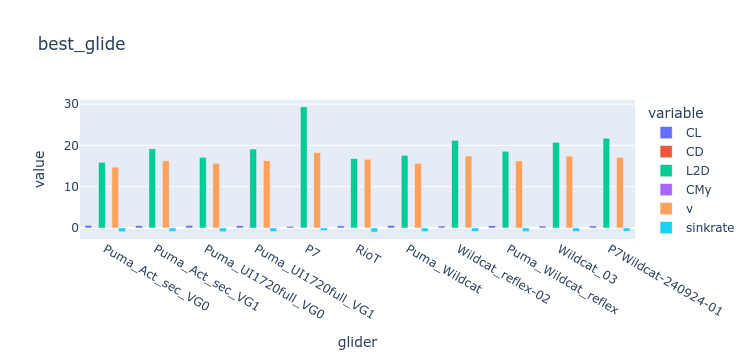

In [31]:
fig = px.bar(dfMulti.xs('best_glide', level=1).drop('AoA',axis=1),barmode='group',title = 'best_glide')

fig.show()

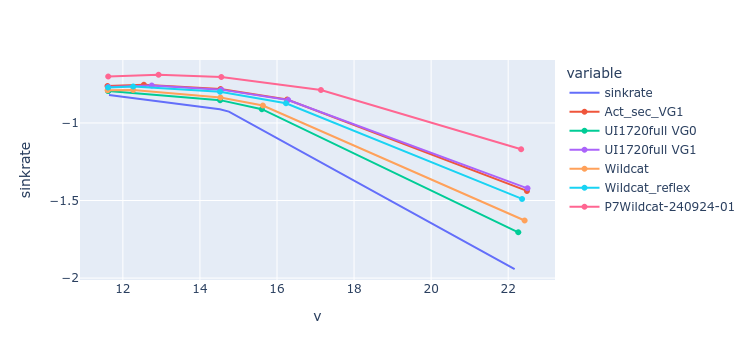

In [32]:
parm = 'sinkrate'
xaxis = 'v'
fig = px.line(dfMulti.loc['Puma_Act_sec_VG0'],x = xaxis, y=[parm])
fig.add_trace(go.Scatter(x = dfMulti.loc['Puma_Act_sec_VG1'][xaxis], y=dfMulti.loc['Puma_Act_sec_VG1'][parm],name = 'Act_sec_VG1'))
fig.add_trace(go.Scatter(x = dfMulti.loc['Puma_UI1720full_VG0'][xaxis], y=dfMulti.loc['Puma_UI1720full_VG0'][parm],name = 'UI1720full VG0'))
fig.add_trace(go.Scatter(x = dfMulti.loc['Puma_UI1720full_VG1'][xaxis], y=dfMulti.loc['Puma_UI1720full_VG1'][parm],name = 'UI1720full VG1'))
fig.add_trace(go.Scatter(x = dfMulti.loc['Puma_Wildcat'][xaxis], y=dfMulti.loc['Puma_Wildcat'][parm],name = 'Wildcat'))
fig.add_trace(go.Scatter(x = dfMulti.loc['Puma_Wildcat_reflex'][xaxis], y=dfMulti.loc['Puma_Wildcat_reflex'][parm],name = 'Wildcat_reflex'))
#fig.add_trace(go.Scatter(x = dfMulti.loc['RioT'][xaxis], y=dfMulti.loc['RioT'][parm],name = 'RioT'))
fig.add_trace(go.Scatter(x = dfMulti.loc['P7Wildcat-240924-01'][xaxis], y=dfMulti.loc['P7Wildcat-240924-01'][parm],name = 'P7Wildcat-240924-01'))
fig.update_yaxes(title_text=parm)
fig.show()

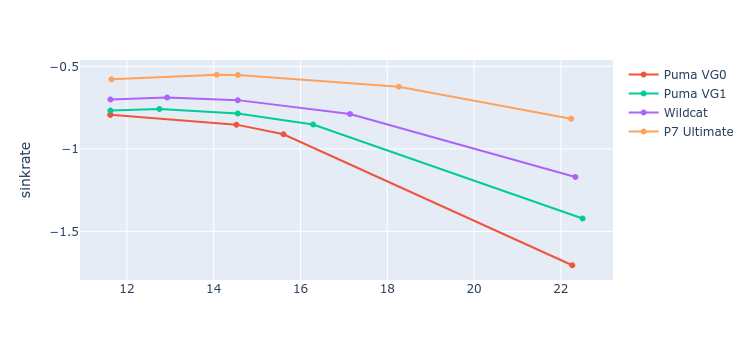

In [33]:
parm = 'sinkrate'
xaxis = 'v'
fig = px.line()
fig.add_trace(go.Scatter(x = dfMulti.loc['Puma_UI1720full_VG0'][xaxis], y=dfMulti.loc['Puma_UI1720full_VG0'][parm],name = 'Puma VG0'))
fig.add_trace(go.Scatter(x = dfMulti.loc['Puma_UI1720full_VG1'][xaxis], y=dfMulti.loc['Puma_UI1720full_VG1'][parm],name = 'Puma VG1'))
fig.add_trace(go.Scatter(x = dfMulti.loc['P7Wildcat-240924-01'][xaxis], y=dfMulti.loc['P7Wildcat-240924-01'][parm],name = 'Wildcat'))
fig.add_trace(go.Scatter(x = dfMulti.loc['P7'][xaxis], y=dfMulti.loc['P7'][parm],name = 'P7 Ultimate'))
fig.update_yaxes(title_text=parm)
fig.show()

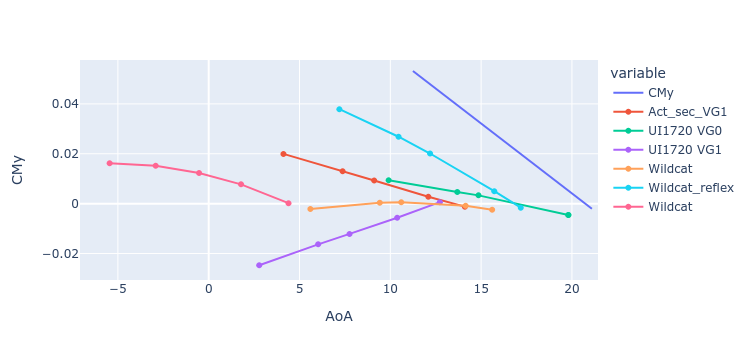

In [34]:
parm = 'CMy'
xaxis = 'AoA'
fig = px.line(dfMulti.loc['Puma_Act_sec_VG0'],x = xaxis, y=[parm])
fig.add_trace(go.Scatter(x = dfMulti.loc['Puma_Act_sec_VG1'][xaxis], y=dfMulti.loc['Puma_Act_sec_VG1'][parm],name = 'Act_sec_VG1'))
fig.add_trace(go.Scatter(x = dfMulti.loc['Puma_UI1720full_VG0'][xaxis], y=dfMulti.loc['Puma_UI1720full_VG0'][parm],name = 'UI1720 VG0'))
fig.add_trace(go.Scatter(x = dfMulti.loc['Puma_UI1720full_VG1'][xaxis], y=dfMulti.loc['Puma_UI1720full_VG1'][parm],name = 'UI1720 VG1'))
fig.add_trace(go.Scatter(x = dfMulti.loc['Puma_Wildcat'][xaxis], y=dfMulti.loc['Puma_Wildcat'][parm],name = 'Wildcat'))
fig.add_trace(go.Scatter(x = dfMulti.loc['Puma_Wildcat_reflex'][xaxis], y=dfMulti.loc['Puma_Wildcat_reflex'][parm],name = 'Wildcat_reflex'))
#fig.add_trace(go.Scatter(x = dfMulti.loc['P7'][xaxis], y=dfMulti.loc['P7'][parm],name = 'P7'))
fig.update_yaxes(title_text=parm)
fig.add_trace(go.Scatter(x = dfMulti.loc['P7Wildcat-240924-01'][xaxis], y=dfMulti.loc['P7Wildcat-240924-01'][parm],name = 'Wildcat'))
fig.update_yaxes(title_text=parm)
fig.show()

In [35]:
#WRITE RESULTS
with open('results-multi.pkl', 'wb') as file_out:
    pickle.dump(dfMulti,file_out,-1)

In [17]:
#path = os.getcwd()
path = '/home/timbo/myrepos/gitlab/wildcat/VSP'
fname = '/P7Wildcat-240924-nowinglet.vsp3'
vsp.VSPRenew()
vsp.ReadVSPFile((path+fname))

analyseVLM(AoAStart=-7, AoAEnd=8, AlphaNpts=12, Xref = 1.176, VLM = True, Sref=None)
res = getResults()

Wing Reference Parms: 
 Sref:  13.500 
 bref:  10.310 
 cref:   1.438 

/home/timbo/anaconda3/envs/vsppytools/lib/python3.12/site-packages/openvsp/vspaero -omp 16 /home/timbo/myrepos/gitlab/wildcat/VSP/P7Wildcat-240924-nowinglet_DegenGeom
VSPAERO v.6.4.8 --- Compiled on: Jul 25 2024 at 05:45:09 PST 




Initializing OPENMP for 16 threads 
NumberOfThreads_: 16 
Mach: 0.000000 
AoA: -7.000000 
ReCref_: 1000000.000000 
Sref            = 13.500000 
Cref            = 1.437938 
Bref            = 10.310000 
X_cg            = 1.176000 
Y_cg            = 0.000000 
Z_cg            = 0.000000 
Mach            = 0.000000 
AoA             = -7.000000, -5.636364, -4.272727, -2.909091, -1.545455, -0.181818, 1.181818, 2.545455, 3.909091, 5.272727, 6.636364, 8.000000 
Beta            = 0.000000 
Vinf            = 100.000000 
Vref            = 100.000000 
Rho             = 0.002377 
ReCref          = 1000000.000000 
ClMax           = 1.600000 
Clo2D           = 0.000000 
MaxTurningAngle = -1.000000 
Sym

In [18]:
Sref = 13.5
L = (78+12+28)*9.81 # Body weight + harness weight + glider weight
v = []
sinkrate = []
for CL,L2D in zip(res['CL'],res['L2D']):
    s = CL2v(CL,Sref,L)
    v.append(s)
    sinkrate.append(-s/L2D)

In [19]:
with open('polars.pkl', 'rb') as input:
    polars=pickle.load(input)
polars

{'Puma_Act_sec_VG0': {'CL': [0.265400582347,
   0.368645249748,
   0.471303464458,
   0.574641938632,
   0.675751074399,
   0.776900689995,
   0.877457799156,
   0.977191300981,
   1.075358565012,
   1.173363920409],
  'CD': [0.02453672172,
   0.027416047727,
   0.031396078513,
   0.036479482803,
   0.042602372377,
   0.049816104088,
   0.058043462186,
   0.067275353967,
   0.077487950784,
   0.088695502197],
  'L2D': [10.824268633575,
   13.464145560455,
   15.037311159222,
   15.784359670205,
   15.898330145651,
   15.635413881417,
   15.160107810393,
   14.570423610806,
   13.924933413212,
   13.278122070919],
  'CMy': [0.03899229017,
   0.025565176741,
   0.01231713401,
   -0.001528087015,
   -0.014384543785,
   -0.027518798029,
   -0.04072367704,
   -0.05389971181,
   -0.066527344768,
   -0.079540604432],
  'AoA': [11.0,
   12.333333,
   13.666667,
   15.0,
   16.333333,
   17.666667,
   19.0,
   20.333333,
   21.666667,
   23.0],
  'sinkrate': [np.float64(-2.121807982399195),
   

In [20]:
polars['P7Wildcat-240924-no winglet'] = dict(res)
polars['P7Wildcat-240924-no winglet']['sinkrate'] = list(sinkrate)
polars['P7Wildcat-240924-no winglet']['v'] = list(v)

In [22]:
with open('polars.pkl', 'wb') as file_out:
    pickle.dump(polars,file_out,-1)

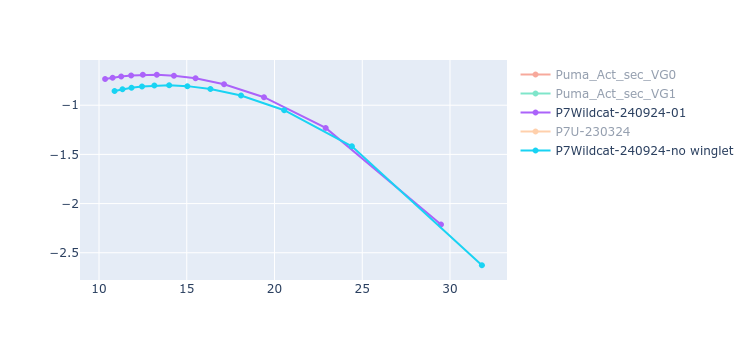

In [21]:
fig = px.line()
parm = 'sinkrate'
for k in polars.keys():
    fig.add_trace(go.Scatter(x = polars[k]['v'], y=polars[k][parm],name = k))
fig.show()

# Wing Optimiser

In [2]:
v1 = 26 * 0.44704 # Convert mph to m/s
v2 = 50 * 0.44704 # Convert mph to m/s
cref = 1.438
Xref = 1.12
Sref = 13.5
L = (78+12+28)*9.81 # Body weight + harness weight + glider weight

In [6]:
#Calc Lists of points describing Leading and Trailing Edges:
def calcLTEpts(secs,chordsmm,sweeps,dihedrals,twists):
    LEpts = [P3(0,0,0)]
    for i in range(1,len(secs)):
        d = np.tan(np.radians(sweeps[i-1]))*(secs[i]-secs[i-1])
        h = np.tan(np.radians(dihedrals[i-1]))*(secs[i]-secs[i-1])
        LEpts.append(P3((LEpts[-1].x+d),(secs[i]),(LEpts[-1].z+h)))
    
    TEpts = []
    for i in range(len(LEpts)):
        TEpts.append(P3(
            LEpts[i].x + (chordsmm[i]*np.cos(np.radians(twists[i]))),
            LEpts[i].y,
            LEpts[i].z - (chordsmm[i]*np.sin(np.radians(twists[i])))))
    return LEpts, TEpts

def calcTLpts(LEpts,TEpts):
    #Vector of tension line from root trailing edge to tip leading edge
    vTL = LEpts[-1] - TEpts[0]
    
    #List of points along tension line
    TLpts = []
    for i in range(len(LEpts)):
        vChL = TEpts[i] - LEpts[i] #Vector of chord line
        r = LEpts[i].y / LEpts[-1].y - LEpts[0].y #ratio of distance along y axis
        x = TEpts[0].x + r*vTL.x
        y = LEpts[i].y
        rc = (x - LEpts[i].x)/(TEpts[i].x - LEpts[i].x)
        z = LEpts[i].z + rc*vChL.z
        TLpts.append(P3(x,y,z))
    return TLpts

def calcTwists(LEpts,TLpts):
    twists = []
    for i in range(len(LEpts)-1):
        vLETL = TLpts[i] - LEpts[i]
        twists.append(-np.degrees(np.arctan(vLETL.z/vLETL.x)))
    twists.append(twists[-1])
    return twists

def wingiser(vmin,vmax, cref, Xref, Sref, stabweight = 0.001, L2Dweight =1, nPts = 3):
    analyseVLM(AoAStart=-5, AoAEnd=20, AlphaNpts=3, Xref = Xref, VLM = True, Sref=Sref)
    res = getResults()
    CLs = res['CL']
    alphas = res['AoA']
    CMs = res['CMy']
    f_CL_al = poly.polyfit(CLs, alphas,2)
    CL1 = v2CL(vmin,Sref,L)
    CL2 = v2CL(vmax,Sref,L)
    AoA1 = poly.polyval(CL1, f_CL_al)
    AoA2 = poly.polyval(CL2, f_CL_al)
    Xref_trim = trimCG(vmin, alphas, CLs, CMs, cref, Xref, L)
    time.sleep(2)
    analyseVLM(AoAStart=AoA2, AoAEnd=AoA1, AlphaNpts=nPts, Xref = Xref_trim, VLM = True, Sref=Sref)
    res = getResults()
    time.sleep(2)
    f_CMy_al = poly.polyfit(res['AoA'], res['CMy'],1)
    score = -stabweight/min(f_CMy_al[1],-1e-8) - L2Dweight * np.mean(res['L2D'])
    return res, score,f_CMy_al[1],np.mean(res['L2D'])

def writeResults(fname, row, rowtitle):
    if os.path.exists(fname):

        with open(fname,'a') as csvfile:
            reswriter = csv.writer(csvfile, delimiter=',', quotechar='|', quoting=csv.QUOTE_MINIMAL)
            reswriter.writerow(row)

    else:

        with open(fname, 'w', newline='') as csvfile:
            reswriter = csv.writer(csvfile, delimiter=',', quotechar='|', quoting=csv.QUOTE_MINIMAL)
            reswriter.writerow(rowtitle)
            reswriter.writerow(row)

In [7]:
writeResults('TEMP.csv', [1,2,3], ['one','two','three'])

In [8]:
#Glider initialise values
AFfolder = '/data/aerofoils/TEMP/'
glider = {
    'secs':[0,603.875,1207.75,1811.625,2415.5,3019.375,3623.25,4227.125,4831],
    'chordsmm':[1855, 1746, 1700, 1647, 1568, 1453, 1272, 947,486],
    'sweeps':[23.03,23.09,23.57,24.5,25.7,27.82,31.22,31.86],
    'dihedrals':[0.05,-1.99,-1.99,-2.18,-2.41,-0.57,4.13,4.13],
    'twists':[0, -3.62, -6.78, -8.9, -11.1, -14.8, -18, -20, -20], #VG OFF
    'ds':[1714, 1595, 1515, 1459, 1383, 1282, 1099, 824, 473],
    'root_file':'data/aerofoils/ui1720reflex.csv',
    'mid_file':'data/aerofoils/ui1720reflex.csv',
    'outb_file':'data/aerofoils/ui1720mod.csv',
    'tip_file':'data/aerofoils/tipsection.csv',
    'rs':[0,0.5,0.75,1]
}


In [12]:
scores = []
hs = []
ress = []
iters = {'dihedralss':[],
         'twistss':[],
         'rss':[]
        }
stabs = []
L2Ds = []
LEpts_init,TEpts_init = calcLTEpts(glider['secs'],
       glider['chordsmm'],
       glider['sweeps'],
       glider['dihedrals'],
       glider['twists'])
TLpts_init = calcTLpts(LEpts_init,TEpts_init)

def wingOpt(params, stabweight, L2Dweight):
    h, th,reflxpt = params[0], params[1], params[2]
    path = os.getcwd()+'/'
    fname = 'blank.vsp3'
    folder = 'examples/'
    AFfolder = 'data/aerofoils/TEMP/'
    hs.append(h)
    vsp.VSPRenew()
    h1 = h + (LEpts_init[-1].z * (LEpts_init[3].y/LEpts_init[-1].y)) # Height above st. line from nose to tip LE
    d1 = np.degrees(np.arctan(h1 / LEpts_init[3].y))
    h2 = th + (LEpts_init[-1].z * (LEpts_init[6].y/LEpts_init[-1].y))
    d2 = np.degrees(np.arctan((h2-h1) / (LEpts_init[6].y-LEpts_init[3].y)))
    d3 = np.degrees(np.arctan((LEpts_init[-1].z-h2) / (LEpts_init[-1].y-LEpts_init[6].y)))
    print(round(d1,2), round(d2,2),round(d3,2))
    glider['dihedrals'] = [d1, d1, d1,d2,d2,d2,d3,d3]
    
    LEpts,TEpts = calcLTEpts(glider['secs'],
                               glider['chordsmm'],
                               glider['sweeps'],
                               glider['dihedrals'],
                               glider['twists'])
    glider['twists'] = calcTwists(LEpts,TLpts_init)
    glider['rs'] = [0,reflxpt,0.75,1]
    #print(glider)
    iters['dihedralss'].append(glider['dihedrals'])
    iters['twistss'].append(glider['twists'])
    iters['rss'].append(glider['rs'])
    generateWing(glider, (path+folder+fname), (path + AFfolder))
    res, score, stab, L2D = wingiser(v1,v2, cref, Xref, Sref, stabweight, L2Dweight,3)
    ress.append(res)
    scores.append(score)
    stabs.append(stab)
    L2Ds.append(L2D)
    print('***********************************')
    print('SCORE:', score)
    print(glider)
    print('************************************')
    writeResults('TEMP.csv', [score,stab,L2D,h,th,reflxpt],
                 ['score','stab','L2D','h', 'th','reflxpt'])
    return score

x0 = [130,40,0.25]
#x0 = [1.726504/2,0.353030/0.195247,-21.630723,-12.001124]
bounds = [(-200,200),(-200,200),(0,0.5)]
stabweight, L2Dweight = 0.001,1 #stab, L2D weighting
opt = scipy.optimize.minimize(wingOpt, x0, bounds = bounds, args=(stabweight, L2Dweight), method = 'Nelder-Mead', tol = 1e-3)

#opt = scipy.optimize.differential_evolution(wingOpt, x0=x0, bounds=bounds, args=(stabweight, L2Dweight), tol = 1e-3)
wingOpt([-38,-79,0.25],stabweight, L2Dweight)

-1.3 -1.4 3.64
/home/timbo/myrepos/gitlab/HG-dev/aerodynamic-modelling/data/aerofoils/TEMP/0.dat
Wing generated with 8 points Area =  13.893352125
/home/timbo/anaconda3/envs/vsppytools/lib/python3.10/site-packages/openvsp/vspaero -omp 16 /home/timbo/myrepos/gitlab/HG-dev/aerodynamic-modelling/examples/blank_DegenGeom
VSPAERO v.6.4.8 --- Compiled on: Mar  4 2024 at 07:19:10 PST 




Initializing OPENMP for 16 threads 
NumberOfThreads_: 16 
Mach: 0.000000 
AoA: -5.000000 
ReCref_: 1000000.000000 
Sref            = 13.500000 
Cref            = 1.437938 
Bref            = 9.662000 
X_cg            = 1.120000 
Y_cg            = 0.000000 
Z_cg            = 0.000000 
Mach            = 0.000000 
AoA             = -5.000000, 7.500000, 20.000000 
Beta            = 0.000000 
Vinf            = 100.000000 
Vref            = 100.000000 
Rho             = 0.002377 
ReCref          = 1000000.000000 
ClMax           = 1.600000 
Clo2D           = 0.000000 
MaxTurningAngle = -1.000000 
Symmetry        = 

TypeError: trimCG() missing 1 required positional argument: 'L'

In [29]:
opt

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: -16.688505548408877
             x: [-5.224e+01  5.041e+01  5.000e-01]
           nit: 77
          nfev: 169
 final_simplex: (array([[-5.224e+01,  5.041e+01,  5.000e-01],
                       [-5.224e+01,  5.041e+01,  5.000e-01],
                       [-5.224e+01,  5.041e+01,  5.000e-01],
                       [-5.224e+01,  5.041e+01,  5.000e-01]]), array([-1.669e+01, -1.669e+01, -1.669e+01, -1.669e+01]))

Not sure whether it makes more sense to fix the TE points or the Tension line points when comparing wings. Tension line gives quite unlikely seeming results near the tip where the distance between the LE and the TL is so small, so I think the tip dihedral was having a disproportionate effect.

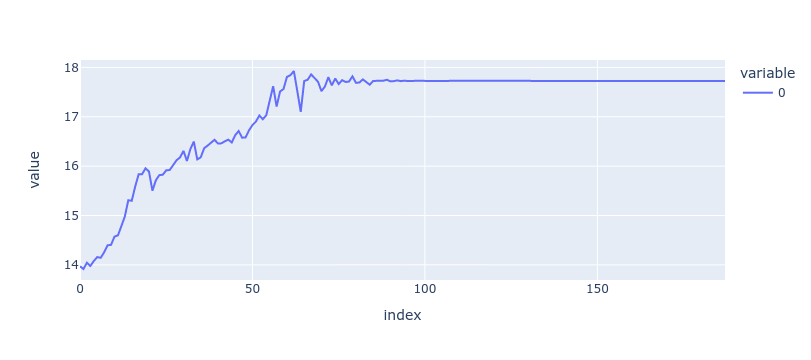

In [42]:
fig = px.line(L2Ds)
#fig.add_trace(go.Scatter(
#    x = hs,
#    y = L2Ds, name = 'L2D'
#))
#fig.add_trace(go.Scatter(
#    x = hs,
#    y = stabs, name = 'stability'
#))
fig.show()

In [44]:
glider

{'secs': [0,
  603.875,
  1207.75,
  1811.625,
  2415.5,
  3019.375,
  3623.25,
  4227.125,
  4831],
 'chordsmm': [1855, 1746, 1700, 1647, 1568, 1453, 1272, 947, 486],
 'sweeps': [23.03, 23.09, 23.57, 24.5, 25.7, 27.82, 31.22, 31.86],
 'dihedrals': [6.0079227800214525,
  6.0079227800214525,
  6.0079227800214525,
  -0.7815850065731527,
  -0.7815850065731527,
  -0.7815850065731527,
  -8.225509278717768,
  -8.225509278717768],
 'twists': [-0.0,
  -2.8101828034408345,
  -4.631571189658383,
  -4.586681240771907,
  -5.201737384902735,
  -7.357470034665638,
  -8.75702753018472,
  -11.880800267416703,
  -11.880800267416703],
 'ds': [1714, 1595, 1515, 1459, 1383, 1282, 1099, 824, 473],
 'root_file': 'data/aerofoils/ui1720reflex.csv',
 'mid_file': 'data/aerofoils/ui1720reflex.csv',
 'outb_file': 'data/aerofoils/ui1720mod.csv',
 'tip_file': 'data/aerofoils/tipsection.csv',
 'rs': [0, 0.4997311111046435, 0.75, 1]}

In [47]:
#Wildcat_03 results
#This is the result with inboard and outboard crank angles and position of extent of reflex section optimised by NM
Wildcat_03 = {'secs': [0,
  603.875,
  1207.75,
  1811.625,
  2415.5,
  3019.375,
  3623.25,
  4227.125,
  4831],
 'chordsmm': [1855, 1746, 1700, 1647, 1568, 1453, 1272, 947, 486],
 'sweeps': [23.03, 23.09, 23.57, 24.5, 25.7, 27.82, 31.22, 31.86],
 'dihedrals': [6.0079227800214525,
  6.0079227800214525,
  6.0079227800214525,
  -0.7815850065731527,
  -0.7815850065731527,
  -0.7815850065731527,
  -8.225509278717768,
  -8.225509278717768],
 'twists': [-0.0,
  -2.8101828034408345,
  -4.631571189658383,
  -4.586681240771907,
  -5.201737384902735,
  -7.357470034665638,
  -8.75702753018472,
  -11.880800267416703,
  -11.880800267416703],
 'ds': [1714, 1595, 1515, 1459, 1383, 1282, 1099, 824, 473],
 'root_file': 'data/aerofoils/ui1720reflex.csv',
 'mid_file': 'data/aerofoils/ui1720reflex.csv',
 'outb_file': 'data/aerofoils/ui1720mod.csv',
 'tip_file': 'data/aerofoils/tipsection.csv',
 'rs': [0, 0.4997311111046435, 0.75, 1]}

## Notes:
### Puma_Act_Sec
Baseline, planform from scan data, actual section based on laser scan data, VG1 twist distribution as scan, VG0, inferred from inflight video and a bit from LiDAR
### Puma_UI1720
Section used at root UI1720 with reflex, next UI1720, modified for Double Surface, then 2R15 section, then tip section. Twist distribution as above
### Puma_UI1720full
Sections as previous, but with UI1720 section in place of 2R15 section, twists as previous
### Puma_Wildcat
Sections as previous, but with twist and dihedral distribution to match the trailing edge to the VG0 case while having a cranked LE
### Puma_Wildcat_reflex
All as previous, but reflex added to mid section

# Work out trim point

In [38]:
v = 28 * 0.44704

cref = 1.438
Xref = 1.197
Sref = 13.5
L = (78+12+28)*9.81 # Body weight + harness weight + glider weight
CL_t = v2CL(v, Sref, L)

In [44]:

glider = 'Wildcat_reflex-02'
alphas = dfMulti.loc[glider]['AoA']
CLs =dfMulti.loc[glider]['CL']
CMs = dfMulti.loc[glider]['CMy']

print('desired trim speed v=',v,'m/s')
print('CL at desired trim speed:', CL_t)
f_CL_al = poly.polyfit(CLs, alphas,1)
alpha_t = poly.polyval(CL_t, f_CL_al) #AoA at desired trim speed
print('alpha at desired trim speed:', round(alpha_t,1), 'degrees')
f_CM_al = poly.polyfit(alphas,CMs,1)
CMy_t = poly.polyval(alpha_t, f_CM_al) #CM at desired trim speed
f_al_CM = poly.polyfit(CMs,alphas,1)
alpha_t_act = poly.polyval(0,f_al_CM) #AoA at desired trim speed
f_al_CL = poly.polyfit(alphas,CLs,1)
CL_t_act = poly.polyval(alpha_t_act, f_al_CL) #CL at actual trim speed
v_t_act = CL2v(CL_t_act, Sref, L) 


print('CMy at desired trim speed:', round(CMy_t, 3))
print('alpha at actual trim speed:', round(alpha_t_act,1), 'degrees')
print('Actual trim speed:', round(v_t_act,2), 'm/s, ',round(v_t_act/ 0.44704,2), 'mph')

desired trim speed v= 12.51712 m/s
CL at desired trim speed: 0.8935159750481922
alpha at desired trim speed: 12.0 degrees
CMy at desired trim speed: -0.089
alpha at actual trim speed: -0.3 degrees
Actual trim speed: nan m/s,  nan mph


/tmp/ipykernel_25411/1889979285.py:3: RuntimeWarning:

invalid value encountered in sqrt



In [45]:
d = CMy_t * cref/CL_t
print(Xref-d)

1.3408013992623513


In [328]:
d

-0.0586901090639199

# Scratch

In [13]:
path = os.getcwd()
fname = '/examples/Puma_Act_sec_VG0.vsp3'
vsp.VSPRenew()
vsp.ReadVSPFile((path+fname))

res = wingiser(v1,v2, cref, Xref, Sref, 6)
res['v'] = [CL2v(CL,Sref,L) for CL in res['CL']]
df = pd.DataFrame(res)
df['sinkrate'] = -df['v']/df['L2D']
df['glider']='Puma_Act_sec_VG0'
df = df.sort_values(by=['v'])
df = df.set_index(['glider',df.index])
dfMulti = df
time.sleep(2)

path = os.getcwd()
fname = '/examples/Puma_Act_sec_VG1.vsp3'
vsp.VSPRenew()
vsp.ReadVSPFile((path+fname))

res = wingiser(v1,v2, cref, Xref, Sref, 6)
res['v'] = [CL2v(CL,Sref,L) for CL in res['CL']]
df = pd.DataFrame(res)
df['sinkrate'] = -df['v']/df['L2D']
df['glider']='Puma_Act_sec_VG1'
df = df.sort_values(by=['v'])
df = df.set_index(['glider',df.index])
dfMulti = pd.concat([dfMulti,df])
time.sleep(2)
path = os.getcwd()
fname = '/examples/Wildcat_reflex-02.vsp3'
vsp.VSPRenew()
vsp.ReadVSPFile((path+fname))

res = wingiser(v1,v2, cref, Xref, Sref, 6)
res['v'] = [CL2v(CL,Sref,L) for CL in res['CL']]
df = pd.DataFrame(res)
df['sinkrate'] = -df['v']/df['L2D']
df['glider']='Wildcat'
df = df.sort_values(by=['v'])
df = df.set_index(['glider',df.index])
dfMulti = pd.concat([dfMulti,df])

    ... GMRES Iter:     1 ... Red:   -0.17802 / -1.00000   ...  Max:   -0.11522 / 1.00000    ... KTRes: 0.00000    
Wake Iter:     4 / 6     ... GMRES Iter:     2 ... Red:   -0.38410 / -1.00000   ...  Max:   -0.32129 / 1.00000    ... KTRes: 0.00000    
Wake Iter:     4 / 6     ... GMRES Iter:     3 ... Red:   -0.55077 / -1.00000   ...  Max:   -0.48796 / 1.00000    ... KTRes: 0.00000    
Wake Iter:     4 / 6     ... GMRES Iter:     4 ... Red:   -0.79227 / -1.00000   ...  Max:   -0.72946 / 1.00000    ... KTRes: 0.00000    
Wake Iter:     4 / 6     ... GMRES Iter:     5 ... Red:   -0.97644 / -1.00000   ...  Max:   -0.91363 / 1.00000    ... KTRes: 0.00000    
Wake Iter:     4 / 6     ... GMRES Iter:     6 ... Red:   -1.16308 / -1.00000   ...  Max:   -1.10027 / 1.00000    ... KTRes: 0.00000    
        4   0.00100  13.95584   0.00000   1.04440   0.01661   0.05150   0.06811   0.05048   0.06709  -0.00013  15.38256   0.98110  -0.18578   0.00000   1.02999   0.00000  -0.00514   0.00000   0.00000

In [7]:
#wildcat
secs= [0,603.875,1207.75,1811.625,2415.5,3019.375,3623.25,4227.125,4831]
chordsmm = [1855, 1746, 1700, 1647, 1568, 1453, 1272, 947,486]
sweeps = [23.03,23.09,23.57,24.5,25.7,27.82,31.22,31.86]
dihedrals = [4.75, 4.75, 4.75 , -3, -3, -3, -3, -3]
#twists = [0, -2, -2.75,  -2.75, -5.5, -8, -12, -16, -20]
twists = [-0.0,
 -1.917410455331127,
 -2.1273191480434424,
 -0.39954095871514284,
 -1.4830513550299267,
 -3.2585891905188893,
 -4.247977673025277,
 -6.593942943396353,
 -6.593942943396353]
ds = [1714, 1595, 1515, 1459, 1383, 1282, 1099, 824, 473]
root_file = 'data/aerofoils/ui1720reflex.csv'
mid_file = 'data/aerofoils/ui1720reflex.csv'
outb_file = 'data/aerofoils/ui1720mod.csv'
tip_file = 'data/aerofoils/tipsection.csv'

LEpts_Wildcat, TEpts_Wildcat = calcLTEpts(secs,chordsmm,sweeps,dihedrals,twists)
TLpts_Wildcat = calcTLpts(LEpts_Wildcat,TEpts_Wildcat)

In [8]:
#PE13
secs= [0,603.875,1207.75,1811.625,2415.5,3019.375,3623.25,4227.125,4831]
chordsmm = [1855, 1746, 1700, 1647, 1568, 1453, 1272, 947,486]
sweeps = [23.03,23.09,23.57,24.5,25.7,27.82,31.22,31.86]
dihedrals = [0.05,-1.99,-1.99,-2.18,-2.41,-0.57,4.13,4.13]
#dihedrals = [0.0,0,0,0,0,-0,0,0]
twists = [0, -3.62, -6.78, -8.9, -11.1, -14.8, -18, -20, -20] #VG OFF
#twists = [0, 0.02, -0.47, -0.81, -2.2, -4.58, -7.74, -10.24, -14.93] #VG ON
ds = [1714, 1595, 1515, 1459, 1383, 1282, 1099, 824, 473]
LEpts_Puma, TEpts_Puma = calcLTEpts(secs,chordsmm,sweeps,dihedrals,twists)
TLpts_Puma = calcTLpts(LEpts_Puma,TEpts_Puma)

calcTwists(LEpts_Puma, TEpts_Puma)


[-0.0,
 -3.6200000000000006,
 -6.780000000000001,
 -8.899999999999999,
 -11.099999999999998,
 -14.800000000000002,
 -18.0,
 -20.0,
 -20.0]

In [37]:
glider = {
    'secs':[0,603.875,1207.75,1811.625,2415.5,3019.375,3623.25,4227.125,4831],
    'chordsmm':[1855, 1746, 1700, 1647, 1568, 1453, 1272, 947,486],
    'sweeps':[23.03,23.09,23.57,24.5,25.7,27.82,31.22,31.86],
    'dihedrals':[0.05,-1.99,-1.99,-2.18,-2.41,-0.57,4.13,4.13],
    'twists':[0, -3.62, -6.78, -8.9, -11.1, -14.8, -18, -20, -20], #VG OFF
    'ds':[1714, 1595, 1515, 1459, 1383, 1282, 1099, 824, 473],
    'root_file':'data/aerofoils/ui1720reflex.csv',
    'mid_file':'data/aerofoils/ui1720reflex.csv',
    'outb_file':'data/aerofoils/ui1720mod.csv',
    'tip_file':'data/aerofoils/tipsection.csv',
    'rs':[0,0.5,0.75,1]
}
LEpts_init, TEpts_init = calcLTEpts(glider['secs'],glider['chordsmm'],glider['sweeps'],glider['dihedrals'],glider['twists'])
h=130
th= 40
h1 = h + (LEpts_init[-1].z * (LEpts_init[3].y/LEpts_init[-1].y)) # Height above st. line from nose to tip LE
d1 = np.degrees(np.arctan(h1 / LEpts_init[3].y))
h2 = th + (LEpts_init[-1].z * (LEpts_init[6].y/LEpts_init[-1].y))
d2 = np.degrees(np.arctan((h2-h1) / (LEpts_init[6].y-LEpts_init[3].y)))
d3 = np.degrees(np.arctan((LEpts_init[-1].z-h2) / (LEpts_init[-1].y-LEpts_init[6].y)))
print(round(d1,2), round(d2,2),round(d3,2))
glider['dihedrals'] = [d1, d1, d1,d2,d2,d2,d3,d3]
LEpts_new, TEpts_new = calcLTEpts(glider['secs'],glider['chordsmm'],glider['sweeps'],glider['dihedrals'],glider['twists'])
print(glider['dihedrals'])

4.0 -2.95 -2.0
[4.002482002027298, 4.002482002027298, 4.002482002027298, -2.946276193503493, -2.946276193503493, -2.946276193503493, -1.999262046188286, -1.999262046188286]


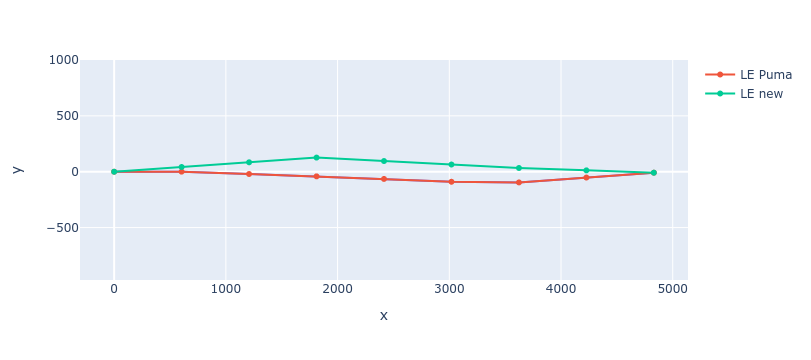

In [38]:
fig = px.line(x=[pt.y for pt in LEpts_init], y=[pt.z for pt in LEpts_init])

fig.add_trace(go.Scatter(
    x = [pt.y for pt in LEpts_init],
    y = [pt.z for pt in LEpts_init], name = 'LE Puma'
))
#fig.add_trace(go.Scatter(
#    x = [pt.y for pt in LEpts_Wildcat],
#    y = [pt.z for pt in LEpts_Wildcat], name = 'LE Wildcat'
#))
fig.add_trace(go.Scatter(
    x = [pt.y for pt in LEpts_new],
    y = [pt.z for pt in LEpts_new], name = 'LE new'
))
#fig.add_trace(go.Scatter(
#    x = [pt.y for pt in TLpts_Wildcat],
#    y = [pt.z for pt in TLpts_Wildcat], name = 'TL Wildcat'
#))
#fig.add_trace(go.Scatter(
#    x = [pt.y for pt in LEpts_Puma],
#    y = [pt.z for pt in LEpts_Puma], name = 'LE'
#))
fig.update_yaxes(
    scaleanchor = "x",
    scaleratio = 1)
fig.show()

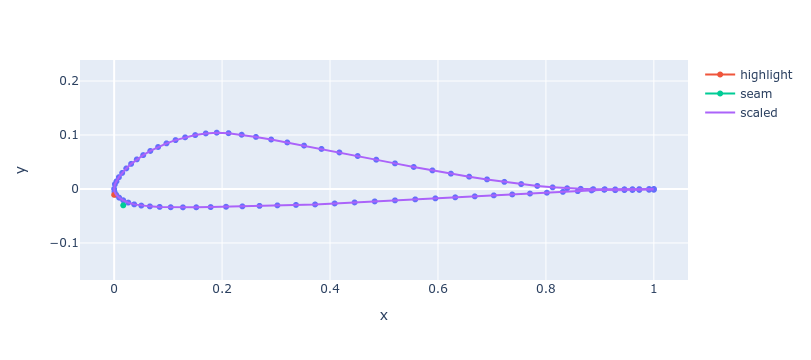

In [127]:
i = 0
t_min = 0.2
t=t_min/chordsmm[i]
tuples = interpolate_section(secs[i]/secs[-1], secpts, rs)
pts = convertDS(tuples,dSurfs[i], 50/chordsmm[0], t)
thick = findThickness(pts)
#print('thickness',thick)

#if thick > maxThick:
#    pts = scaleSection(pts, scaleTH = maxThick/thick, minthick = t)
sec = pts
t=t_min/chordsmm[i]
tuples = interpolate_section(secs[i]/secs[-1], secpts, rs)
pts = convertDS(tuples,dSurfs[i], 50/chordsmm[0], t)
thick = findThickness(pts)
#print('thickness',thick)

#if thick > maxThick:
#    pts = scaleSection(pts, scaleTH = maxThick/thick, minthick = t)

scaled = pts
#sec=interpolate_section(1, secpts, rs)
#sec = convertDS(sec,ds=0.9, seam = 0.01, tol = 0.001)
xs = [pt[0]  for pt in sec]
ys = [pt[1]  for pt in sec]
xs_2 = [pt.u  for pt in scaled]
ys_2 = [pt.v for pt in scaled]

fig = px.scatter(x=xs, y=ys)
fig.add_trace(go.Scatter(
    x = [0],
    y = [-0.010825118110236221], name = 'highlight'
))
fig.add_trace(go.Scatter(
    x = [0.016852],
    y = [-0.030336634699325016], name = 'seam'
))

fig.add_trace(go.Scatter(
    x = xs_2,
    y = ys_2, name = 'scaled'
))
fig.update_yaxes(
    scaleanchor = "x",
    scaleratio = 1,
  )
fig.show()

In [104]:
i = 0

pts=interpolate_section(secs[i]/secs[-1], secpts, rs)
pts = convertDS(pts,dSurfs[i], 50/chordsmm[0], t)
thick = findThickness(pts)
#print('thickness',thick)
t=0.4/chordsmm[i]
if thick > maxThick:
    pts = scaleSection(pts, scaleTH = maxThick/thick, minthick = t)


In [92]:
P2(1,1).Len()

1.4142135623730951

In [88]:
help(P2)

Help on class P2 in module CODE.basicgeo:

class P2(P2)
 |  P2(u, v)
 |  
 |  Method resolution order:
 |      P2
 |      P2
 |      builtins.tuple
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  Arg(self)
 |  
 |  Len(self)
 |  
 |  LenLZ(self)
 |  
 |  Lensq(self)
 |  
 |  __add__(self, a)
 |      Return self+value.
 |  
 |  __mul__(self, a)
 |      Return self*value.
 |  
 |  __neg__(self)
 |  
 |  __repr__(self)
 |      Return a nicely formatted representation string
 |  
 |  __rmul__(self, a)
 |      Return value*self.
 |  
 |  __sub__(self, a)
 |  
 |  assertlen1(self)
 |  
 |  ----------------------------------------------------------------------
 |  Static methods defined here:
 |  
 |  APerp(v)
 |  
 |  CPerp(v)
 |  
 |  ConvertLZ(p)
 |  
 |  Dot(a, b)
 |  
 |  DotLZ(a, b)
 |  
 |  ZNorm(v)
 |  
 |  __new__(self, u, v)
 |      Create new instance of P2(u, v)
 |  
 |  ----------------------------------------------------------------------
 |  Methods inherited fr

In [53]:
path = os.getcwd()+'/'
AFfolder = 'data/aerofoils/3E140/'

for i in range (0,8):
    fname = str(i)
    dxfname = path+AFfolder+fname+'.dxf'
    datname = path+AFfolder+fname+'.dat'
    AFpts = dxf2dat(dxfname,datname, dmax = 1e-2)

In [54]:
i = 3
fname = str(i)
dxfname = path+AFfolder+fname+'.dxf'
datname = path+AFfolder+fname+'.dat'
AFpts = dxf2dat(dxfname,datname, dmax = 1e-2)

In [55]:
LEpt = P2(1,0)
TEpt = P2(0,0)
for pt in AFpts:
    if pt.u < LEpt.u:
        LEpt = pt
    if pt.u > TEpt.u:
        TEpt = pt
LEpt,TEpt

(P2(0.0, 0.0), P2(1.0, -0.00040847546678952337))

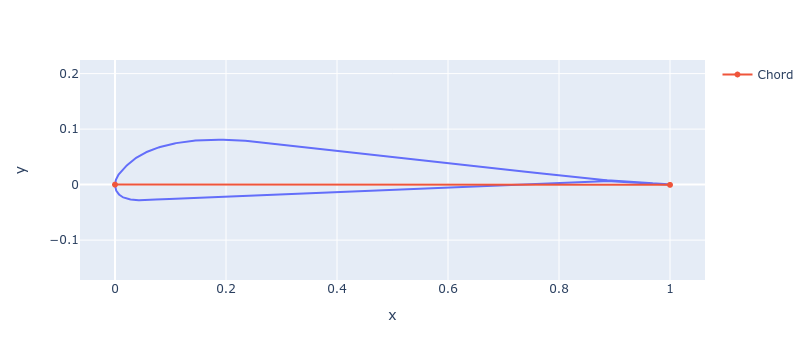

In [56]:
fig = px.line(x=[pt.u for pt in AFpts], y=[pt.v for pt in AFpts])

fig.add_trace(go.Scatter(
    x = [pt.u for pt in [LEpt,TEpt]],
    y = [pt.v for pt in [LEpt,TEpt]], name = 'Chord'
))
fig.update_yaxes(
    scaleanchor = "x",
    scaleratio = 1,
  )
fig.show()